# 线性回归

利用加州普查数据，建立一个加州房价模型。这个数据包含每个街区组的人口、收入中位数、房价中位数等指标。

街区组是美国调查局发布样本数据的最小地理单位（一个街区通常有 600 到 3000 人）。我们将其简称为“街区”。

你的模型要利用这个数据进行学习，然后根据其它指标，预测任何街区的的房价中位数。

## 加载数据

In [1]:
import pandas as pd
HOUSING_PATH="./dataset/housing/housing.csv"
#加载数据集
def load_housing_data(housing_path=HOUSING_PATH):
    return pd.read_csv(housing_path)

housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
#数据信息
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
# 离海洋距离是个离散值，统计信息
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
#describe()方法展示了数值属性的概括
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


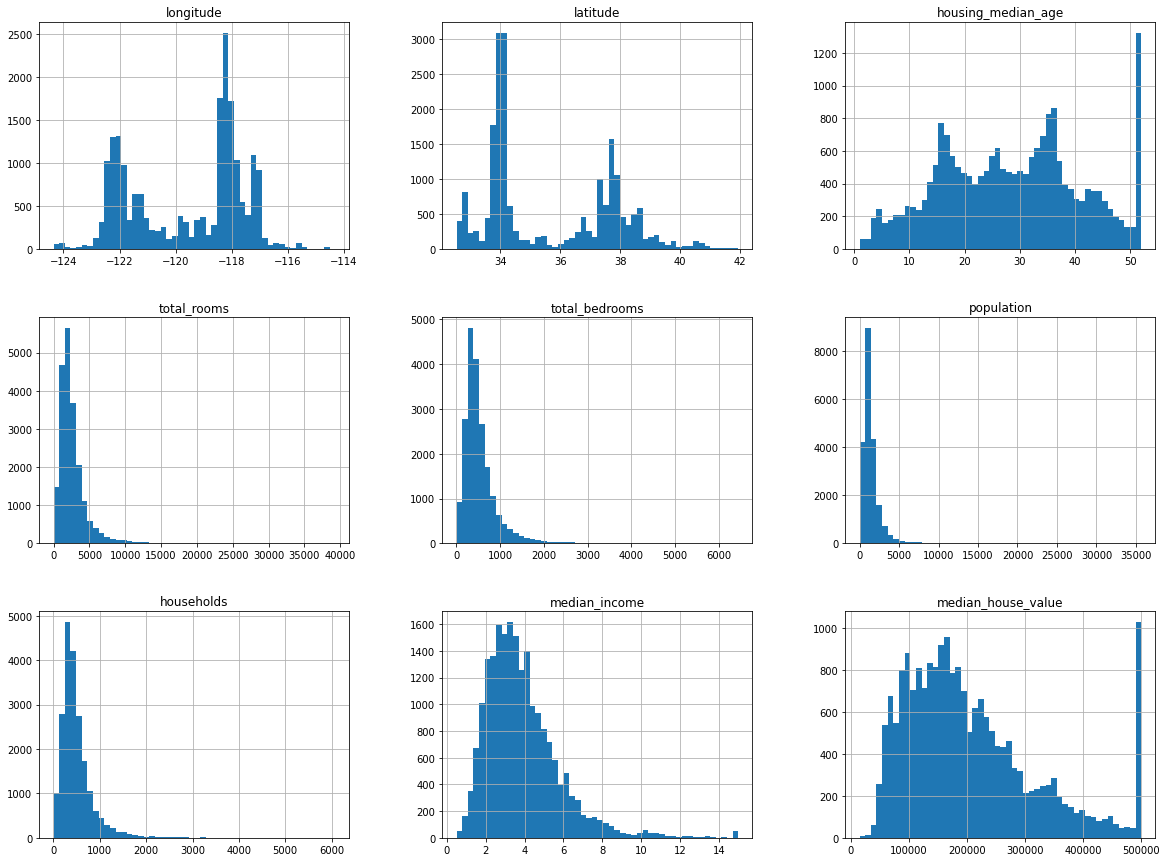

In [5]:
#绘图
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

### 切分数据集
测试集和训练集

In [6]:
# 切分测试集和训练集，测试集比例0.2
# from sklearn.model_selection import train_test_split
# train_set,test_set=train_test_split(housing,test_size=0.2,random_state=42)
#为了更好的训练效果，使用分层抽样而非随机抽样

新建属性income_cat，对收入中位数进行分类，根据该属性进行分层抽样

In [7]:
import numpy as np
housing['income_cat']=np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5,5.0,inplace=True)
housing['income_cat'].head()

0    5.0
1    5.0
2    5.0
3    4.0
4    3.0
Name: income_cat, dtype: float64

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
train_set=[]
test_set=[]
for train_index,test_index in split.split(housing,housing['income_cat']):
    train_set=housing.loc[train_index]
    test_set=housing.loc[test_index]
# 验证分层抽样比例
print(housing['income_cat'].value_counts()/len(housing))
# 删除自定义属性
for set in (train_set,test_set):
    set.drop(['income_cat'],axis=1,inplace=True)
train_set.head()

# 数据集副本
housing_train_copy=train_set.copy()

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64


### 数据可视化

<function matplotlib.pyplot.legend(*args, **kwargs)>

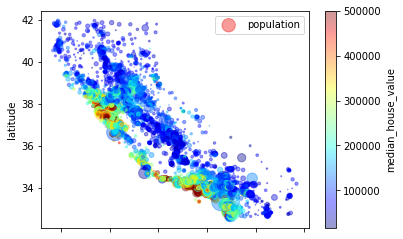

In [10]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
    s=housing["population"]/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend

#### 查找关联
因为数据集并不是非常大，你可以很容易地使用corr()方法计算出每对属性间的标准相关系数（standard correlation coefficient，也称作皮尔逊相关系数）：

In [11]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64